In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
import os
import pathlib
import random

In [2]:
base_path = r"C:\Users\Kalpesh Patil\Desktop\my workspace\Research paper\Breast-Cancer-Detection-Using-CNN-on-Ultrasound-Images-main\Dataset_Images"

In [3]:
# Paths to the individual image folders
benign_path = os.path.join(base_path, 'benign')
malignant_path = os.path.join(base_path, 'malignant')
normal_path = os.path.join(base_path, 'normal')

In [4]:
from pathlib import Path

# Convert the path strings to Path objects
benign_path = Path(benign_path)
malignant_path = Path(malignant_path)
normal_path = Path(normal_path)

# Count the number of PNG files in each directory
benignImageCount = len(list(benign_path.glob('*.png')))
malignantImageCount = len(list(malignant_path.glob('*.png')))
normalImageCount = len(list(normal_path.glob('*.png')))
totalImageCount = benignImageCount + malignantImageCount + normalImageCount

In [5]:
print("Total number of Images:", totalImageCount)
print("No.of Benign (non-dangerous) Images: {}({})".format(benignImageCount, round(benignImageCount*100/totalImageCount, 2)))
print("No.of Malignant (dangerous) Images: {}({})".format(malignantImageCount, round(malignantImageCount*100/totalImageCount, 2)))
print("No.of Normal (No Traces) Images: {}({})".format(normalImageCount, round(normalImageCount*100/totalImageCount, 2)))

Total number of Images: 1587
No.of Benign (non-dangerous) Images: 900(56.71)
No.of Malignant (dangerous) Images: 421(26.53)
No.of Normal (No Traces) Images: 266(16.76)


In [6]:
#Build the Cnn
batch_size = 32
img_height = 224
img_width = 224

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_data = image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1587 files belonging to 3 classes.
Using 1270 files for training.
Found 1587 files belonging to 3 classes.
Using 317 files for validation.


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an image data generator for augmentation
from tensorflow.keras.applications import VGG16

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)




In [14]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers in the base model
base_model.trainable = False

In [15]:
# Create a new model on top of the pre-trained base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [18]:
# Compile the model 
epochs = 5
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using TensorFlow Datasets
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    verbose=1
)

# Evaluate the model on validation data
loss, accuracy = model.evaluate(test_data)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 516s 13s/step - accuracy: 0.5572 - loss: 1.9399 - val_accuracy: 0.8139 - val_loss: 0.4781
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 548s 14s/step - accuracy: 0.7816 - loss: 0.5754 - val_accuracy: 0.8233 - val_loss: 0.4177
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 554s 14s/step - accuracy: 0.8204 - loss: 0.4043 - val_accuracy: 0.8360 - val_loss: 0.3841
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 539s 14s/step - accuracy: 0.8391 - loss: 0.3576 - val_accuracy: 0.8612 - val_loss: 0.3583
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 549s 14s/step - accuracy: 0.8580 - loss: 0.3412 - val_accuracy: 0.8612 - val_loss: 0.3526
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 11s/step - accuracy: 0.8302 - loss: 0.4139
Test Loss: 0.3519795536994934
Test Accuracy: 0.8611987233161926


10/10 ━━━━━━━━━━━━━━━━━━━━ 135s 13s/step


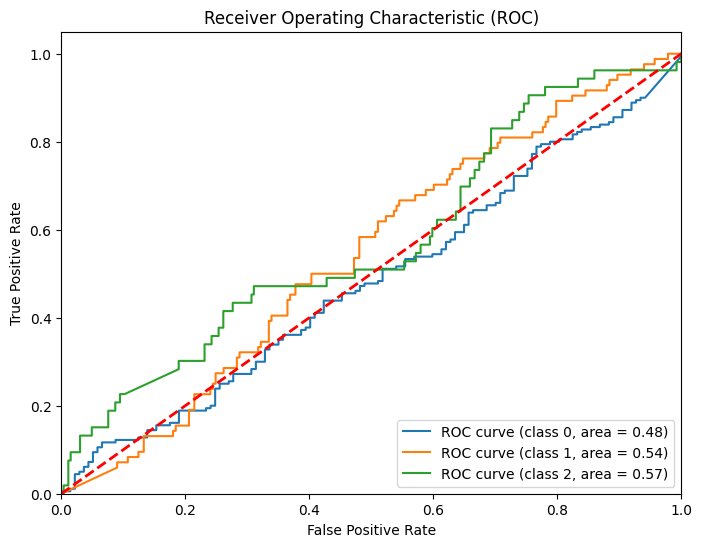

In [15]:
from sklearn.metrics import roc_curve, auc
# Generate predictions for validation data
y_true = validation_data.classes
y_pred = model.predict(validation_data)

# Calculate ROC curve and AUC for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot one-vs-all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [19]:
#keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
#accuracy vs lost
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

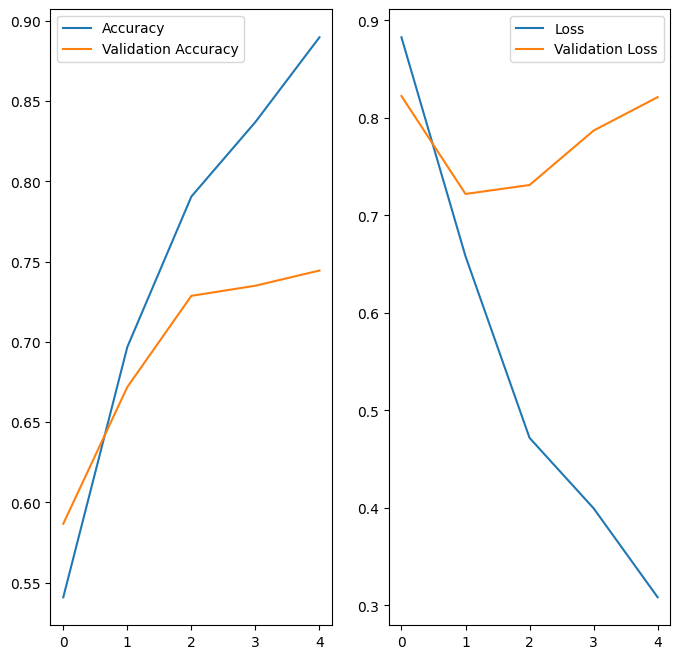

In [57]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [21]:
model.evaluate(test_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 11s/step - accuracy: 0.8816 - loss: 0.3151


[0.35194969177246094, 0.8611987233161926]

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,912,843 (56.89 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 132,104 (516.04 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


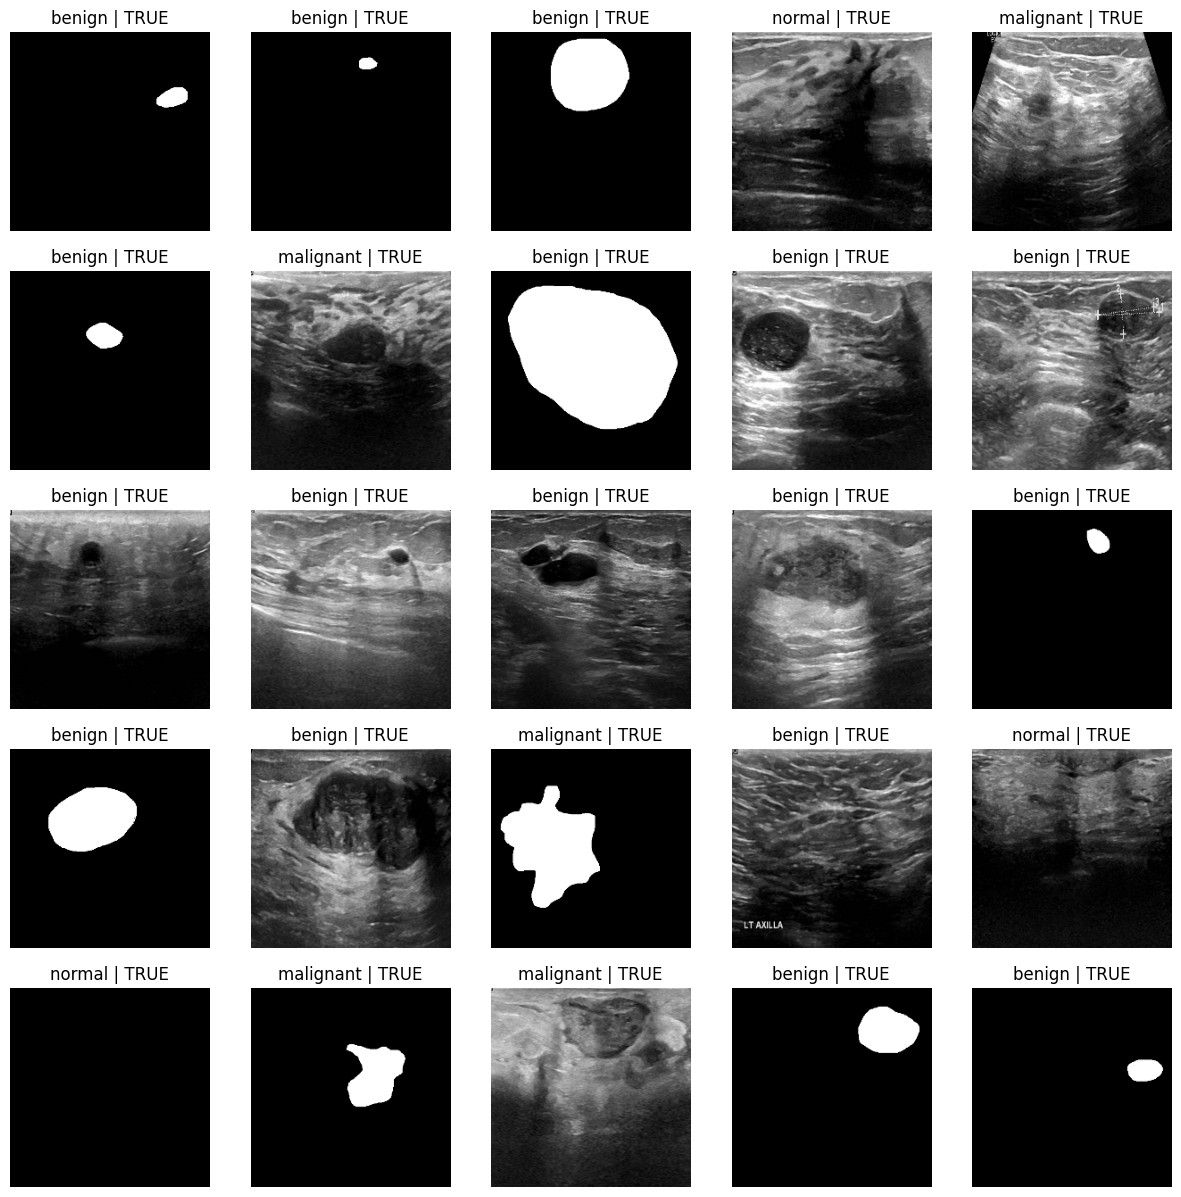

In [23]:
plt.figure(figsize=(15, 15))
class_names = test_data.class_names
result = ' | False'
for images, labels in test_data.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result)
        plt.axis("off")

In [24]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(test_data)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 102s 10s/step - accuracy: 0.8581 - loss: 0.3600
Test Loss: 0.3522823452949524
Test Accuracy: 0.8611987233161926
